# NewReno

In [1]:
import time
import random
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import ion
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.base import RegressorMixin
from tensorflow.python import training
#%matplotlib inline
#%matplotlib notebook
import os 
import gc

In [2]:
'''
  
class Server_FederatedOMS:
  
  In the central server, we decide to use only the highest
  accuracy holder model as the central server updated model, send it to the local
  clients after the computation.



  def ReceiveModelsFromClients(self, parIdCliente):
    print("Recebido Modelo do Cliente 1")
  def Consolidar(self):
    print("Consolidado todos os modelos")
  def FeedBackConsolidatedModel(self):
    print ("Modelos enviados")

  clients = ['Cliente1', 'Cliente2']


class Server_FederatedBMA():

owever, in the BMA technique, the central server receives
four models with model accuracy performances from the local servers or clients.
In the central server, we sort the model using their performances. Then we
decide to use the two best models or half of the models based on performances.
Then BMA technique loops through each model’s hidden layers and neurons to do
the sum of the weights and average them accordingly.

  def ReceiveModelsFromClients(self)
  def Consolidar(self)
  def FeedBackConsolidatedModel(self)

    clients[] = ['Cliente1', 'Cliente2']



    def __init__(self, parCentralServer, parId):
      self.id=parId
      self.centralServer = parCentralServer
      #self.centralServer.RegisterClient(self,self)


'''

class LoggingCallback(keras.callbacks.Callback):
    """Callback that logs message at end of epoch.
    """


    def __init__(self, parExpDir):
       
        self.exp_dir = parExpDir


    def on_epoch_end(self, epoch, logs=None):

        
        file_path = self.exp_dir+"/readme.txt"

        f = open(file_path, "a")
        msg = "{Epoch: %i} %s" % (epoch, ", ".join("%s: %f" % (k, v) for k, v in logs.items()))
        f.write(msg+"\n")
        f.close()



class Client():



    #resultadoTreinamento = np.eye(10)

    def __init__(self,
                 parId,
                 parTraininPath, 
                 parTestPath, 
                 parEpoch,
                 parUnits, 
                 parBatchSize, 
                 parPrevisionWindow, 
                 parStepsOut,
                 parCongestionProtocol,
                 parNumWebNodes, 
                 parRTTToRouter,
                 parExpTime,
                 parExpDir,
                 par_exp_dir_out_from_fit,
                 par_exp_dir_out_from_file):
 
      self.id = parId
      self.id_in_server=-1 #-1 indica que não foi cadastrado no servidor
      self.trainingPath=parTraininPath
      self.testPath = parTestPath
      self.T = parPrevisionWindow
      #centralServer = Server_FederatedAMA()
      #confusionMatrizModelClient = np.full((2,2), 1)
      #confusionMatrizModelServer = np.full((2,2), 2)
      self.currentConfusionMatriz =np.full((2,2), 0) # Apesar de ser obtidas a partir de listas, a matriz de comfusão é numpy
      self.weightsClientModel = []
      self.weightsServerModel = []
      #self.total_ConsolidateModels=0;
      #self.base = pd.DataFrame()
      #self.base_treinamento =  np.array([])
      self.real_congestion_test = np.array([])
      self.latest_prevision = np.array([])
      #self.test_vectors = []
      #self.previsores = []
      #self.real_congestion = []
      #self.regressor = Sequential()
      self.input_shape =0;
      self.base_teste=[]
      self.len_base_teste = 0;
      self.n_steps_out = parStepsOut
      self.congestion_protocol = parCongestionProtocol
      self.mean_real_congestion = 0;
      self.mean_predicted_congestion=0;
      #self.windowMemory = parWindowMemory #substituido pela unit
      self.exp_units=parUnits
      self.exp_batch_size=parBatchSize
      self.exp_num_web_nodes=parNumWebNodes;
      self.exp_RTT_to_router=parRTTToRouter;
      self.exp_epoch=parEpoch
      self.exp_time=parExpTime
      self.exp_dir = parExpDir
      self.num_plot = 0;
      self.last_server_type_sender = "AMA" #AMA, INTERCHANGE
      self.total_model_received_form_server=0
      self.model_saves = 0
      self.exp_dir_out_from_fit = par_exp_dir_out_from_fit
      self.exp_dir_out_from_file =par_exp_dir_out_from_file



 
 
      #self.centralServer.RegisterClient(self,self)

    def NormalizeFeatures(self, data):

       data['ack_ewma(ms)'] = data['ack_ewma(ms)'].div(data['ack_ewma(ms)'].max())
       data['send_ewma(ms)'] = data['send_ewma(ms)'].div(data['send_ewma(ms)'].max())
       data['rtt_ratio'] = data['rtt_ratio'].div(data['rtt_ratio'].max())
       data['cwnd (Bytes)'] = data['cwnd (Bytes)'].div(data['cwnd (Bytes)'].max())
       return data

    def SplitBase(self, base):
      training_base = base.iloc[0:base.shape[0]-200,:]
      teste = base.iloc[base.shape[0]-200:base.shape[0],:]
      return training_base, teste


    
    def RefreshFromServerModel(self):
      if(self.ServerModelIsBetter()):
          print("Pesos atualizados de acordo com o modelo do servidor")
          return True
      else:
          print("Pesos Mantidos de acordo com o modelo do cliente")
          return False

    def LoadTrainingDataSet(self):
      base = pd.read_csv(self.trainingPath)
      base = base.dropna()
      base = self.NormalizeFeatures(base)
      base_treinamento, self.base_teste = self.SplitBase(base)
      base_treinamento = base.iloc[:, [1,2,3,4,5]].values
      #base_treinamento = base.iloc[:, [1,2,3,5]].values
      #print("Veja a base de treinamento normalizada")
      #print(base_treinamento)
      #input();
      #normalizador = MinMaxScaler(feature_range=(0,1))
      #base_treinamento = normalizador.fit_transform(base_treinamento)
      #base_treinamento = base.iloc[:, [2,4,6]].values
      previsores=[]
      real_congestion = []

      #real_congestion_ahead = []

      #base_treinamento.shape[0] número de linhas dos dados de treinamento
      #"-self.n_steps_out", pois, se não estoura, não dá para fazer 5 a frente a partir do último                                                                   
      for i in range(self.T, base_treinamento.shape[0]):
        end_ix = i+self.n_steps_out
        if end_ix > base_treinamento.shape[0]:
          break;
        #previsores.append(base_treinamento[i-self.T:i, 0:4])#o que é considerado é o limite superior do rante -1
        previsores.append(base_treinamento[i-self.T:i, 0:4])#o que é considerado é o limite superior do rante -1 e sem a informação do percentual de ocupação do buffer
        real_congestion.append(base_treinamento[(i-1)+self.n_steps_out,4])#
    
        '''
        #Se quiser repetir os últimos valores
        real_congestion_ahead.clear();
        
        for k in range (self.n_steps_out):
          if i+k < base_treinamento.shape[0]:
            #print(i+k,"---> ", base_treinamento[i+k, 3])
            real_congestion_ahead.append(base_treinamento[i+k, 4])#O resultado é do último cara
          else:
            real_congestion_ahead.append(base_treinamento[base_treinamento.shape[0]-1, 4])#O resultado é do último cara
        real_congestion.append(real_congestion_ahead.copy())
        '''
        #print(real_congestion)
        #input("real_congestion ++")
      '''
      *********************************SOBRE O RESHAPE**************************************
      Veja que nesse caso não é necessário fazer o reshape, uma vez que o array previsores , já sai
      no formato [samples, timesteps, features]
      *sample: Ajanela deslizante em T vai gerar um número de inserções em previsores, correspondente ao número de samples
      *timesteps:inserções de exatamente T arrays, que nesse caso é equivalente ao timestamps, ou seja, quantas leituras no tempo estamos 
      considerando para prever. 
      *features: T arrays de n features

      no nosso caso:

      seja

      base_treinamento = np.array([
                          [0.0618679825944638,1.48529333300134E-05,0.849658635009267,	1,	0.8],
                          [0.0618642722717276,1.29963255564132E-05,0.856697088426436,0.960369635326222,0.8],
                          [0.061861180336114,	1.13717804155358E-05,0.863735541843606,0.915095509799057,	0.78],
                          [0.0618582945295414,9.95030786359384E-06,0.870773995260775,0.892458447035475,	0.76],
                          [0.0620104177617272,8.70651048799314E-06,0.877953217746287,0.869821384271893,	0.74],
                          [0.06214357712215,  7.6182100159712E-06, 0.8851324402318,0.860208385016125,	0.72],
                          [0.0622600400302597	,6.66593154081194E-06	,0.892311662717312,0.847184321508311,	0.7],
                          [0.0623620739055063	,5.83269009821044E-06	,0.899490885202825,	0.847184321508311,	0.68],
                          [0.0624511216511761	,5.1035993896084E-06,0.906670107688337,0.847184321508311,	0.69],
                          [0.062529244557678	,4.46565835855882E-06	,0.91384933017385	,0.847184321508311,	0.78],
                          [0.0625974732702166,3.9074488405761E-06	,0.921028552659362	,0.847184321508311,	0.58],
                          [0.0626572506920783	,3.41901106601549E-06	,0.928207775144875,0.847184321508311,	0.48],
                          [0.0627096074684674	,2.99163023643782E-06	,0.935386997630387,0.847184321508311,	0.38],
                          [0.0627553681155477	,2.61767645688309E-06	,0.9425662201159,0.0226370627635822,	0.18],
                          [0.0627953571494827	,2.29048023874991E-06	,0.949745442601412,0.0226370627635822,	0.28],


      ])


      ou seja 15 samples, 4 features e uma a ser prevista. Vamos considerar T=3 e n_steps_out=4(n_steps_out=0 já é um a frente, ou seja tem que bater em T)  
      Daí só vai sobrar 15-(T+n_steps_out-1= 3+4-1) = 9 samples
      a saída será

      previsores
             1               2              3             4
    1  [[6.18679826e-02 1.48529333e-05 8.49658635e-01 1.00000000e+00]
      T [6.18642723e-02 1.29963256e-05 8.56697088e-01 9.60369635e-01]
        [6.18611803e-02 1.13717804e-05 8.63735542e-01 9.15095510e-01]] 0.7
    2  [[6.18642723e-02 1.29963256e-05 8.56697088e-01 9.60369635e-01]
      T [6.18611803e-02 1.13717804e-05 8.63735542e-01 9.15095510e-01]
        [6.18582945e-02 9.95030786e-06 8.70773995e-01 8.92458447e-01]] 0.68
    3[  [6.18611803e-02 1.13717804e-05 8.63735542e-01 9.15095510e-01]
      T [6.18582945e-02 9.95030786e-06 8.70773995e-01 8.92458447e-01]
        [6.20104178e-02 8.70651049e-06 8.77953218e-01 8.69821384e-01]] 0.69
    4[  [6.18582945e-02 9.95030786e-06 8.70773995e-01 8.92458447e-01]
      T [6.20104178e-02 8.70651049e-06 8.77953218e-01 8.69821384e-01]
        [6.21435771e-02 7.61821002e-06 8.85132440e-01 8.60208385e-01]] 0.78
    5[  [6.20104178e-02 8.70651049e-06 8.77953218e-01 8.69821384e-01]
      T [6.21435771e-02 7.61821002e-06 8.85132440e-01 8.60208385e-01]
        [6.22600400e-02 6.66593154e-06 8.92311663e-01 8.47184322e-01]] 0.58
    6[  [6.21435771e-02 7.61821002e-06 8.85132440e-01 8.60208385e-01]
      T [6.22600400e-02 6.66593154e-06 8.92311663e-01 8.47184322e-01]
        [6.23620739e-02 5.83269010e-06 8.99490885e-01 8.47184322e-01]] 0.48
    7[  [6.22600400e-02 6.66593154e-06 8.92311663e-01 8.47184322e-01]
      T [6.23620739e-02 5.83269010e-06 8.99490885e-01 8.47184322e-01]
        [6.24511217e-02 5.10359939e-06 9.06670108e-01 8.47184322e-01]] 0.38
    8[  [6.23620739e-02 5.83269010e-06 8.99490885e-01 8.47184322e-01]
      T [6.24511217e-02 5.10359939e-06 9.06670108e-01 8.47184322e-01]
        [6.25292446e-02 4.46565836e-06 9.13849330e-01 8.47184322e-01]] 0.18
    9[  [6.24511217e-02 5.10359939e-06 9.06670108e-01 8.47184322e-01]
      T [6.25292446e-02 4.46565836e-06 9.13849330e-01 8.47184322e-01]
        [6.25974733e-02 3.90744884e-06 9.21028553e-01 8.47184322e-01]] 0.28

          ou seja
          [samples,timestepes,features]

      '''
      previsores, real_congestion = np.array(previsores), np.array(real_congestion)
      '''
      print("shape previsores: ")
      print(previsores.shape)
      #input("shape dos previsores")
      print("Amostra Previsores")      
      print(previsores[0])
      print(previsores[1])
      print(previsores[2])
      #input("Amostra Previsores Exibidos acima")
      print("Real Congestion: ")
      print(real_congestion)
      #input("exibidos os Congestionamentos Reais")
      '''
      self.input_shape = previsores.shape[1]
      return previsores, real_congestion
      
    def GetModel(self):
      regressor = Sequential()
      #regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (self.input_shape, 4)))# 4, pois são 4 previsores
      #regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (self.input_shape, 4)))# 3, retirando o valor do preenchimento do buffer.
      #regressor.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = (self.input_shape, 4))))
      #regressor.add(Dropout(0.3)) #zerar 30% das entradas para evitar o overfiting

      #regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (self.input_shape, 4)))
      #regressor.add(LSTM(units = 20, return_sequences = True, input_shape = (self.input_shape, 4)))
      #regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (self.input_shape, 4)))
      #regressor.add(LSTM(units = 6, return_sequences = True, input_shape = (self.input_shape, 4)))
      regressor.add(LSTM(units = 2*self.exp_units, return_sequences = True, input_shape = (self.input_shape, 4)))
      regressor.add(Dropout(0.3)) #zerar 30% das entradas para evitar o overfiting
      
      
      #regressor.add(LSTM(units = 50, return_sequences = True))
      #regressor.add(LSTM(units = 10, return_sequences = True))
      #regressor.add(LSTM(units = 6, return_sequences = True))
      regressor.add(LSTM(units = self.exp_units, return_sequences = True))
      regressor.add(Dropout(0.3))


      #regressor.add(LSTM(units = 50, return_sequences = True))
      #regressor.add(LSTM(units = 10, return_sequences = True))
      #regressor.add(LSTM(units = 6, return_sequences = True))
      regressor.add(LSTM(units = self.exp_units, return_sequences = True))
      regressor.add(Dropout(0.3))

      #regressor.add(LSTM(units = 50))
      #regressor.add(LSTM(units = 10))
      #regressor.add(LSTM(units = 6))
      regressor.add(LSTM(units = self.exp_units))
      regressor.add(Dropout(0.3))

      '''
      Segundo https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
      as saídas de cada unidade da LSTM e, portanto, a saída global é a dimenção do número de previsores, que, no nosso
      caso, é 4. Daí esses 4 estão sendo levados em um softmax de tres neurônios, pois há tres categorias no final"
      ''' 
      #regressor.add(Dense(units = 1, activation = 'sigmoid', name="client_"+str(self.id))) #para uma previsão
      regressor.add(Dense(units = self.n_steps_out, activation = 'sigmoid', name="client_"+str(self.id)))
      
      #regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics = ['mean_absolute_error'])

      return regressor

    def GetModelFromFile(self, parSave):

      arquivo = open(self.exp_dir+"/model_"+str(parSave)+".json",'r')
      estrutura_regressor = arquivo.read()
      arquivo.close()
      regressor = model_from_json(estrutura_regressor)
      regressor.load_weights(self.exp_dir+"/model_weights_"+str(parSave)+".h5")
      #Atualiza a lista de pesos, só para manter a coerencia, pois os pesos já estão no regressor
      #mas devem também ser os pesos atuais do cliente, pelo qual está pervendo
      self.weightsClientModel.clear()
      for e in regressor.get_weights():
        self.weightsClientModel.append(e)
      return regressor


    def RefreshModel(self, parInitial=False): #Constroi na primeira vez e atualiza, a partir da avaliação do servidor cetral
      #pensar melhor no critério
      previsores,real_congestion = self.LoadTrainingDataSet()

      #regressor = Sequential()
      regressor = self.GetModel();
      #indica que já foi feito um treinamento ou consolidação de modelos prévia
      if(len (self.weightsClientModel)):
        regressor.set_weights(self.weightsClientModel)      

      opt = keras.optimizers.Adam(learning_rate=0.0001)
      regressor.compile(optimizer = opt, loss = 'mean_squared_error',metrics = ['mean_absolute_error'])
      #es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
      #rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
      #mcp = ModelCheckpoint(filepath = self.exp_dir+"/pesos.h5", monitor = 'loss',  save_weights_only = True, save_freq='epoch',verbose = 1)
      #regressor.fit(previsores, real_congestion, epochs = 50, batch_size = 32, callbacks = [es, rlr, mcp])
      regressor.fit(previsores, real_congestion, epochs = self.exp_epoch, batch_size = self.exp_batch_size,verbose=0,
                callbacks=[LoggingCallback(parExpDir=self.exp_dir)])
      #self.weightsClientModel = regressor.get_weights().copy()
      regressor_json = regressor.to_json()
      with open(self.exp_dir+"/model_"+str(self.model_saves)+".json",'w') as json_file:
        json_file.write(regressor_json)
      regressor.save_weights(self.exp_dir+"/model_weights_"+str(self.model_saves)+".h5")
      self.model_saves=self.model_saves+1
      self.weightsClientModel.clear()
      for e in regressor.get_weights():
        self.weightsClientModel.append(e)


    #Apenas abre o arquivo e carrega os pesos. Falta Completar, pois os certo é continuar um treinamento a partir do modeo carregado 
    def RefreshModelFromFile(self, parSave): #Constroi na primeira vez e atualiza, a partir da avaliação do servidor cetral
      
      #regressor = self.GetModelFromFile(parSave);
      #regressor.load_weights(exp_dir+"/model_weights_"+str(parSave)+".h5")
      regressor=self.GetModelFromFile(parSave)

      #Implementar o treinamento falta completar
      #no final atualiza so pesos
      self.weightsClientModel.clear()
      for e in regressor.get_weights():
        self.weightsClientModel.append(e)

 
    def GetMapedMatrix(self,parPrevisoes):
      classe_teste2 = []
      previsoes2 =  []

      for i in range(0, self.len_base_teste):
        if(self.real_congestion_test[i,0] < 0.3):
          classe_teste2.append(0)
        elif (self.real_congestion_test[i,0] >= 0.3 and self.real_congestion_test[i,0] < 0.75):
          classe_teste2.append(1)
        else:
          classe_teste2.append(2)

      for i in range(0, parPrevisoes.shape[0]):
        if(parPrevisoes[i,0] < 0.3):
          previsoes2.append(0)
        elif (parPrevisoes[i,0] >= 0.3 and parPrevisoes[i,0] < 0.75):
          previsoes2.append(1)
        else:
          previsoes2.append(2)

      return classe_teste2, previsoes2


    def EvalueteServerModel(self, parServerModel):

      test_vectors = self.LoadTestData()
      updated = False
      for i in range(0,self.total_model_received_form_server):
        print(f"====== Cliente: {self.id} analisando modelo {i} do servidor:")
        #É importante lembrar que o GetPrevision faz a previsão com os pesos que lá estiverem! 
        previsoesCliente = self.GetPrevision()
        if(self.last_server_type_sender == "AMA"):#uma unica lista
          parServerModel.set_weights(self.weightsServerModel)
        elif (self.last_server_type_sender == "INTERCHANGE"):#várias listas
          parServerModel.set_weights(self.weightsServerModel[i])
        else:
          print("Tipo de Servidor Incompatível")
          quit();
        previsoesServidor = parServerModel.predict(test_vectors)
        
        '''
        Observe que os previsores teste tem 90 quádruplas que conduzem ao resultado
        do último estado, da quádrupla 90. Prontamente preparado para pevisões....
        '''
        '''
        Abordagem baseada na matriz de confusão, abandonada por se entender que o melhor é verificar a tendência.
        classe_teste2,previsoes2 = self.GetMapedMatrix(previsoes)
        matriz = confusion_matrix(classe_teste2,previsoes2)
        currentSum = 0
        newSum = 0
        if(self.currentConfusionMatriz.ndim > 1): # as vezes a rede pode errar ao ponto de dar só uma categoria, daí cai no else...
          for i in range (0, len(self.currentConfusionMatriz)):
            currentSum = currentSum + self.currentConfusionMatriz[i][i]
        else:
          currentSum = self.currentConfusionMatriz[i]
        if(matriz.ndim > 1):
          for i in range (0, len(matriz)):
            newSum = newSum + matriz[i][i]
       else:
          newSum = matriz[i]
        if(newSum > currentSum):
          self.currentConfusionMatriz = np.array(matriz)
          #self.regressor.set_weights(self.weightsServerModel)
          self.weightsClientModel.clear()
          for e in self.weightsServerModel:
            self.weightsClientModel.append(e)
          updated = True
      '''
        #print("====== Média dos Congestionamentos Previstos com modelo central: ",previsoes.mean())
        
        print("====== Erro médio com modelo servidor: ",np.mean(abs(previsoesServidor[:,self.n_steps_out-1]-self.real_congestion_test)))
        print("====== Erro médio com modelo cliente: ",np.mean(abs(previsoesCliente[:,self.n_steps_out-1]-self.real_congestion_test)))
        #if abs(previsoes.mean()-self.mean_real_congestion) < abs(self.mean_predicted_congestion-self.mean_real_congestion):
        #Observe que se houver mais de um modelo consolidad, o melhor prevalece, pois a próxima previsão
        #é comparada com a do melhor medolo, pois o modelo vigente sempre é substituído caso o do servidor central 
        #seja melhor
        if np.mean(abs(previsoesServidor[:,self.n_steps_out-1]-self.real_congestion_test)) < np.mean(abs(previsoesCliente[:,self.n_steps_out-1]-self.real_congestion_test)):
          self.weightsClientModel.clear()
          if(self.last_server_type_sender == "AMA"):
            for e in self.weightsServerModel:
              self.weightsClientModel.append(e)
          elif (self.last_server_type_sender == "INTERCHANGE"):
            for e in self.weightsServerModel[i]:
              self.weightsClientModel.append(e)

          self.mean_predicted_congestion = previsoesServidor.mean();
          updated = True        

      print (f"Modelo do Servidor avaliado pelo cliente {self.id}")
      return updated 

    def LoadTestData(self, parLoadTestFromFile=False):
      #Esse if é pensado na hora de testar o modelo com dados de outros experimentos, completamente
      #alheisos com os que foram treinados 
      if(parLoadTestFromFile): #Daí pega o testPath, que, a princípio, é um experimento diferente daquele para no qual os
                               #pesos salvos foram treinados
        print("From File")
        base = pd.read_csv(self.testPath)
        base = base.dropna()
        base = self.NormalizeFeatures(base)
        base_treinamento, external_base_teste = self.SplitBase(base)
        self.real_congestion_test = external_base_teste.iloc[:, 5:6].values
        frames = [base_treinamento, external_base_teste]
        base_completa = pd.concat(frames)
        self.len_base_teste = len(external_base_teste)
      else: #caminho normal, durante o treinamento
        base = pd.read_csv(self.trainingPath)
        base = base.dropna()
        base = self.NormalizeFeatures(base)
        base_treinamento, external_base_teste = self.SplitBase(base)
        #A base teste está sendo preparada no SplitBase
        #base_teste = pd.read_csv(self.testPath)
        #base_teste = base_teste.dropna()
        #base_teste = self.NormalizeFeatures(base_teste)
        self.real_congestion_test = self.base_teste.iloc[:, 5:6].values #Observe que aqui não há drop, por isso é 5:6, de Ack a Last Router Ocupation Ack Arriaval(Packets)
        #self.real_congestion_test = base_teste.iloc[:, 9:10].values      
        #print("antes de deslocar")
        #print(self.real_congestion_test)
        frames = [base_treinamento, self.base_teste]
        base_completa = pd.concat(frames)
        self.len_base_teste = len(self.base_teste)
      '''
        A ideia do laço a seguir é 'shiftar' o congestionamento real de n_steps_out, a fim de se fazer a comparação
        com o última posição dos vetores previstos pela rede neural.
      
        for k in range (base_teste.shape[0]):
              if(k+self.n_steps_out < base_teste.shape[0]):
              self.real_congestion_test[k][0] = self.real_congestion_test[k+self.n_steps_out-1][0]
          else:
            self.real_congestion_test[k][0] = self.real_congestion_test[base_teste.shape[0]-1][0]
      '''
      self.mean_real_congestion = self.real_congestion_test.mean()
      #print("====== Média dos Congestionamentos: ",self.mean_real_congestion)
      #print("observe os valores de teste deslocados")
      #print(self.real_congestion_test.shape)
      #print(self.real_congestion_test)
      #input("Veja se foi feito o deslocamento corretamente")


      base_completa = base_completa.drop('#Ack', axis =1) #
      #base_completa = base_completa.drop('ack_ewma(ms)', axis =1)
      #base_completa = base_completa.drop('send_ewma(ms)', axis =1)
      #base_completa = base_completa.drop('rtt_ratio', axis =1)
      #base_completa = base_completa.drop('cwnd (Bytes)', axis =1)
      base_completa = base_completa.drop('Last Router Ocupation Ack Arriaval(Packets)', axis =1)#O que se quer prever
      base_completa = base_completa.drop('Last Router Ocupation Packet Sent(Packets)', axis =1)
      base_completa = base_completa.drop('Network Situation', axis =1)
      base_completa = base_completa.drop('AckArrival(ms)', axis =1)
      base_completa = base_completa.drop('TSInsideAck(ms)', axis =1)
      base_completa = base_completa.drop('RTTAck(ms)', axis =1)
      entradas = base_completa[len(base_completa) - self.len_base_teste - (self.T+self.n_steps_out-1):].values
      #base_teste_features = base_teste.iloc[:, [1,2,3,6]].values
      #print("#############len(base_teste): ",len(self.base_teste))
      
      X_teste = []

      for i in range(self.T+self.n_steps_out-1, self.len_base_teste+self.T+self.n_steps_out-1): # para as duzentas previsoes, o mesmo tramanho do Teste.csv, ou seja 290-90
        #X_teste.append(entradas[i-self.T:i,0:4])
        #end_ix = i+self.n_steps_out
        if i >= entradas.shape[0]:
          break;
        X_teste.append(entradas[i-(self.T+self.n_steps_out-1):i-(self.n_steps_out-1),0:4])

        #previsores.append(base_treinamento[i-self.T:i, 0:4])#o que é considerado é o limite superior do rante -1
        #real_congestion.append(base_treinamento[(i-1)+self.n_steps_out,4])#
        #print("Previsor")
        #print(X_teste[i-self.T])
        #input("Exibido mais um previsor")


      test_vectors = np.array(X_teste) # equivalente ao X_teste
      '''
      print("Amostra Testadores")      
      print(test_vectors[0])
      print(test_vectors[1])
      print(test_vectors[2])
      input("Amostra Previsores Exibidos acima")
      print("Real Congestion: ")
      print(self.real_congestion_test)
      input("exibidos os Congestionamentos Reais")
      '''

      return test_vectors
    '''   
    def RefreshConfusionClientMatrix(self):
      #confrontar resultados
      self.confusionMatrizModelClient = np.full((2,2),random.randint(0,9))

    def RefreshConfusionServerMatrix(self):
      #confrontar resultados
      self.confusionMatrizModelServer = np.full((2,2),random.randint(0,9))
    '''       
    #parTotalModels abrange todos os modelos, inclusive o do cliente, apesar de ser descartado
    def ReceiveModelFromServer(self, parCandidateMatrix, parReturnededModels, parServerType):
      print("Cliente ", self.id, " Recebido Modelo do Servidor")
      serverModel=[]
      self.total_model_received_form_server = parReturnededModels
      self.last_server_type_sender = parServerType
      print("parServerType: ",parServerType)
      self.weightsServerModel.clear()
      for i in range(0,parReturnededModels):
        if (self.last_server_type_sender == "AMA"):
          for e in parCandidateMatrix:
            self.weightsServerModel.append(e)
        elif (self.last_server_type_sender == "INTERCHANGE"):
          for e in parCandidateMatrix[i]:
              serverModel.append(e)
          self.weightsServerModel.append(serverModel.copy())
          serverModel.clear()
  
      
    def SendModelToServer(self):
      self.centralServ.ReceiveModelsFromClients(self.id)
      print("Client", self.id, "Sending Model To Server")
    '''
    def TreinarModelo(self):
      print("Cliente ", self.id, "treinando Modelo")
      time.sleep(random.randint(0,9))
      self.RefreshConfusionClientMatrix()

    '''

   
    def GetPrevision(self, parSave=0,parLoadTestFromFile=False): #evalueta indica que é uma avaliação do modelo recebido como parametro, no caso do servidor

      #parSave se refere aos pesos e modelo salvos a no round parSave. Por
      #isso só é usado se parLoadTestFromFile for True
      test_vectors = self.LoadTestData(parLoadTestFromFile)# parLoadTestFromFile indica que é para pegar do test_client, 
                                                           #que, a princípio, veio de outro experimento

      #print("Observe os testadores")
      #print("shape: ",test_vectors.shape)
      #print(test_vectors)
      #input("testadores exibidos")

      if(not parLoadTestFromFile):
        regressor=self.GetModel()
        regressor.set_weights(self.weightsClientModel)

      else:
        print("FromFile")
        regressor = self.GetModelFromFile(parSave)

      

      previsoes = regressor.predict(test_vectors)
      #print("Observe as previsoes:")
      #print(previsoes)
      #input("Observe as previsoes")
      self.latest_prevision = np.empty((previsoes.shape[0],1))      
      for i in range(previsoes.shape[0]):
        self.latest_prevision[i][0]=previsoes[i][self.n_steps_out-1]
      
      '''
      A ideia do laço a seguir é tomar a última posição dos vetores previstos pela rede neural, que corresponde a 
      n_steps_out no futuro.
      latest_prevision = np.empty((previsoes.shape[0],1))
      
      for i in range(previsoes.shape[0]):
        latest_prevision[i][0]=previsoes[i][self.n_steps_out-1]
      '''
      #self.mean_predicted_congestion = previsoes.mean();
      #print("====== Média dos Congestionamentos Previstos Internamente: ",self.mean_predicted_congestion)
      #print("Observe as previsoes mais remotas:")
      #print(latest_prevision)
      #input("As previsões Remotas foram obtidas corretamente?")
      
      
      #Esperar dominar as previsões a frente
      #previsoes.mean()
      #self.real_congestion_test.mean()
      #ion() # enables interactive mode 
 
      
    
      
      #input("Observe a tendência")
      #print("Observe as previsoes")
      #print("shape: ",previsoes.shape)
      #print(previsoes)
      #pausa=input("previsoes Tabuladas")
     
      #previsoes = parNeuralModel.predict(self.test_vectors)
     
   
      #Observe que os previsores teste tem 90 quádruplas que conduzem ao resultado
      #do último estado, da quádrupla 90. Prontamente preparado para pevisões....
      
      #classe_teste2 = np.array([])
      #previsoes2 =  np.array([])
      #classe_teste2,previsoes2 = self.GetMapedMatrix(previsoes) 
      #self.currentConfusionMatriz = confusion_matrix(classe_teste2,previsoes2) 
      
      #return self.currentConfusionMatriz # Com a configuração corrente, essa é a matriz....
      return previsoes
        
    def PlotResults(self,parLoadFromFile=False):
      fig, graph = plt.subplots()
      graph.plot(self.real_congestion_test, color = 'red', label = 'Cng Real')
      #if(parLoadFromFile):
        #graph.plot(self.latest_prevision*3.5, color = 'blue', label = 'Cng Previsto')
      #else:
      graph.plot(self.latest_prevision, color = 'blue', label = 'Cng Previsto')
      graph.set_xlabel('ACK')
      graph.set_ylabel('Ocupacao Fila')
      graph.title.set_text('Previsão do Congestionamento {:0>3}'.format(self.id))
      #graph.legend()
      textbox = '\n'.join([
                          'Units: '+str(self.exp_units),
                          'Epochs: ' + str(self.exp_epoch),
                          '',
                          'Batch Size: '+str(self.exp_batch_size),
                          'Features Before: ' +str(self.T),
                          'Round Aheads: ' + str(self.n_steps_out),
                          'Congestion Protocol '+self.congestion_protocol,
                          'RTT to Router: ' + str(self.exp_RTT_to_router),
                          '',
                          '',
                          '...',
                          '...',
                          '...',
                          ])
      
      bbox = dict(boxstyle='square', facecolor='lavender', alpha=0.5)
      fig.text(1.1,1,textbox,fontsize=10,transform=graph.transAxes, bbox=bbox, verticalalignment='top')
      self.num_plot=self.num_plot+1
      #tem que passar dpi=300, bbox_inches='tight' para salvar igual mostra! ver **https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.04-Saving-Plots/**
      if(parLoadFromFile):
        fig.savefig(self.exp_dir_out_from_file+"/client{id:0>3}_{num_plot:0>3}".format(id=self.id,num_plot=self.num_plot)+".png",dpi=300, bbox_inches='tight')
      else:
        fig.savefig(self.exp_dir_out_from_fit+"/client{id:0>3}_{num_plot:0>3}".format(id=self.id,num_plot=self.num_plot)+".png",dpi=300, bbox_inches='tight')
      plt.legend()
      plt.show()
      
            

    def ServerModelIsBetter(self):
      '''
      Observe, pelas duas linhas abaixo, que a avaliação do modelo do servidor federated é uma
      fase independente das avaliações internas do cliente, uma vez que se utiliza um
      modelo destino, que será incorporado ao servidor apenas se oferecer um resultado
      melhor, quando comparada a última previsão interna do cliente.
      '''
      regressorServer = self.GetModel()
      #regressorServer.set_weights(self.weightsServerModel)
      return self.EvalueteServerModel(regressorServer)



class Server_Federated():

  def __init__(self):
    self.clients = []
    self.ReceivedModel = [False,False,False]
    self.consolidateWeightMatrix = []
    self.total_clients = 0;

  def PrintRegistredClients(self):
    print("Registring Clients")
    for x in self.clients:
      print("Client ", x.id)
  
  def RegisterClient(self, parCliente):
    parCliente.id_in_server = self.total_clients
    self.clients.append(parCliente)
    self.total_clients = self.total_clients+1
    #print("Cliente ", parCliente.id, " Regitrado com sucesso")

  '''
  def ReceiveModelsFromClient(self, parId):
   print("Recebido Modelos dos Cliente ", parId)    
   self.ConsolideModels()

  '''  
    



class Server_FederatedAMA(Server_Federated):
  '''
  During the aggregation,
  we first sum and average the neuron weights of each model. Then we store the
  average value in the designated global model position. In the neural network
  model, the same process is calculated for every neuron. After completing Al-
  gorithm 2, the central server aggregated model is sent to all the clients for the
  next learning phase
  '''
  def __init__(self):
    Server_Federated.__init__(self)

  def ConsolidateModels(self):

    numberClients = len(self.clients)
    #lstTemp = []
    #arrays_in_Layer=[]
    #lst_arrays_in_Layer = []
    #lst_consolidated_arrays_in_layer = [] #as camadas, composta por arraysconsolidados
    #consolidated_arrays_in_layer = [] #arrays da camada
    #consolidated_array = None
    consolidated_model = []
    clients_weighted_models = []
    '''
    #Cada weightsClientModel é uma lista de numpyarrays crua "flatem", isto é
    se um modelo tem, por exemplo, 3 camadas e cada uma com dois arrays, o 
    weightsClientModel será uma lista de 6 numpy´s, com os dois primeiros vetores da 
    primeira camada no início, seguidos dos dois da segunta e, depois, os dois da terceira.
    Nada de listas. É uma Listona de numpys
    '''
    for client in self.clients:
        #print(client.weightsClientModel)
        #input("pesos acima")
        clients_weighted_models.append(client.weightsClientModel)
    
    
    #Criando a estrutura do Modelo
    #for model in client_weighted_model:
    for i in range(0,len (clients_weighted_models)):#Cada Clinte
       for j in range (0, len(clients_weighted_models[i])):
            if(i==0):
                consolidated_model.append(clients_weighted_models[i][j])#alocando a lista com os pesos do primeiro modelo.
            else:
                consolidated_model[j] = consolidated_model[j] + clients_weighted_models[i][j]
            if (i == numberClients - 1):
                consolidated_model[j] = consolidated_model[j]/numberClients
 
    #self.consolidateWeightMatrix = consolidated_model # cuidado com isso!
    self.consolidateWeightMatrix.clear()
    for e in consolidated_model:
        self.consolidateWeightMatrix.append(e)

    
    print("Amostra Peso Clientes:")
    for client in self.clients:
      print("============================")
      print(client.weightsClientModel[0][0][0:4])
    print("Amostra Peso Consolidado: ")
    print(self.consolidateWeightMatrix[0][0][0:4])
  
  def FeedBackConsolidatedModel(self):
    for x in self.clients:
      x.ReceiveModelFromServer(self.consolidateWeightMatrix.copy(),1,"AMA")
    self.consolidateWeightMatrix.clear()
    print("Feedbacks Enviados e descartados")



class Server_FederatedInterChange(Server_Federated):
  '''
  Manda os modelos dos outros clientes para cada um dos clientes cadastrados 
  '''
  def __init__(self):
    Server_Federated.__init__(self)

  def ConsolidateModels(self): # no interchance deve-se passar o  cliente, 
                                          # justamente para que o própio modelo não seja passado

    #numberClients = len(self.clients)
    #lstTemp = []
    #arrays_in_Layer=[]
    #lst_arrays_in_Layer = []
    #lst_consolidated_arrays_in_layer = [] #as camadas, composta por arraysconsolidados
    #consolidated_arrays_in_layer = [] #arrays da camada
    #consolidated_array = None
    clients_weighted_models = []
    '''
    #Cada weightsClientModel é uma lista de numpyarrays crua "flatem", isto é
    se um modelo tem, por exemplo, 3 camadas e cada uma com dois arrays, o 
    weightsClientModel será uma lista de 6 numpy´s, com os dois primeiros vetores da 
    primeira camada no início, seguidos dos dois da segunta e, depois, os dois da terceira.
    Nada de listas. É uma Listona de numpys
    '''
    for client in self.clients:
        #print(client.weightsClientModel)
        #input("pesos acima")
        clients_weighted_models.append(client.weightsClientModel)
    
    
    #Criando a estrutura do Modelo
    #for model in client_weighted_model:
    client_model=[]
    self.consolidateWeightMatrix.clear()
    for i in range(0,len (clients_weighted_models)):#Cada Clinte
      for j in range (0, len(clients_weighted_models[i])):
        client_model.append(clients_weighted_models[i][j])
      self.consolidateWeightMatrix.append(client_model.copy())
      client_model.clear()
  
 
    #self.consolidateWeightMatrix = consolidated_model # cuidado com isso!
    print("Amostra Peso Clientes:")
    for client in self.clients:
      print(f"========Cliente {client.id}=============")
      print(client.weightsClientModel[0][0][0:4])
    print("Amostra Peso Consolidado por INTERCHANGE: ")
    print(self.consolidateWeightMatrix[0][0][0][0:4])

  def FeedBackConsolidatedModel(self):
    consolidateWeightMatrix_to_client=[]
    for x in self.clients:
      for i in range (len(self.consolidateWeightMatrix)):
         if(i != x.id_in_server):
           consolidateWeightMatrix_to_client.append(self.consolidateWeightMatrix[i])
      x.ReceiveModelFromServer(consolidateWeightMatrix_to_client.copy(),len(consolidateWeightMatrix_to_client),"INTERCHANGE")
      consolidateWeightMatrix_to_client.clear()
    self.consolidateWeightMatrix.clear()
    print("Feedbacks Enviados e descartados")

    





 

In [3]:
from numpy.ma.core import exp
'''
Server::ConsolidateModels----------------Server::FeedBackConsolidatedModel--------------Client::RefreshModel
'''

#numClients = 3; #Can be gotten from user

#lstClients = [];

def GeneralTraining(parExpDir, parTrainingPath, parTestPath,parExpDescription):

    objServeAMA = Server_FederatedAMA()
    objServerInterChange = Server_FederatedInterChange()

    #for i in range (numClients):
      #objClient = Client(objServe,i)
      #lstClients.append(objClient)

    #for x in lstClients:
      #print("Cliente ", x.id, "Criado com Sucesso");


    #for x in lstClients:
     #objServe.RegisterClient(x)

    #objServe.PrintRegistredClients()

    '''
    for i in range (0,10):
      print("==================Rodada ",i" ========================")
      for x in lstClients:
        x.TreinarModelo
      for x in lstClients:
        x.SendModelToServer
      objServe.ConsolidateModels
      objServe.FeedBackConsolidatedModel()
      for x in lstClients:
        x.AtualizarModelo();
    '''

    local_env=True;
    exp_time=time.ctime();

    exp_time = exp_time.replace(":", "_" )
    exp_time = exp_time.replace(" ", "_" )
    '''
    if(not local_env):
      exp_dir = "/content/drive/MyDrive/Colab Notebooks/Exp_000007/"
    else:
      exp_dir = "./Exp_000007/"
    '''
    exp_dir=os.path.join(parExpDir, exp_time)
    exp_dir_out_from_fit = exp_dir+"/from_fit" #para armazenar saídas obtidas de pesos/modelos treinados (fit)
    exp_dir_out_from_file = exp_dir+"/from_fle" #para armazenar saídas obtidas de pesos/modelos recuperados do arquivo 
    #criando efetivamednte os diretórios
    os.mkdir(exp_dir)
    os.mkdir(exp_dir_out_from_fit)
    os.mkdir(exp_dir_out_from_file)



    exp_epoch = 50
    exp_units = 100
    exp_batch_size=1
    exp_T=30
    exp_steps_out =5
    exp_congestion_protocol = "BBR"
    exp_web_nodes= 2

    #Registando dados gerais, comum a todos os clientes, no readme.txt

    file_path = exp_dir+"/readme.txt"

    f = open(file_path, "w")

    f.write("Epocas: "+ str(exp_epoch)+"\n")
    f.write("Units: " +str(exp_units)+"\n")
    f.write("Batch Size:" + str(exp_batch_size)+"\n")
    f.write("Janela Previsao: "+ str(exp_T)+"\n")
    f.write("Ahead Steps:"+str(exp_steps_out)+"\n")
    f.write(parExpDescription)
    f.close()



    client01_id=0
    '''
    if(not local_env):
      client01_training_path= "/content/drive/MyDrive/Colab Notebooks/Exp_000007/training_client01.csv"
      client01_test_path = "/content/drive/MyDrive/Colab Notebooks/Exp_000007/test_client01.csv"
    else:
      client01_training_path= "./Exp_000007/training_client01.csv"
      client01_test_path = "./Exp_000007/test_client01.csv"
    '''
    client01_training_path = parTrainingPath
    client01_test_path = parTestPath
    
    client01_epoch = exp_epoch
    client01_units = exp_units;
    client01_batch_size=exp_batch_size
    client01_T=exp_T
    client01_steps_out = exp_steps_out
    client01_congestion_protocol = exp_congestion_protocol
    client01_web_nodes= exp_web_nodes
    client01_RTT_router = "50ms"


    #Registando dados relativos ao cliente 0, comum a todos os clientes, no readme_cliente_000.txt

    file_path = exp_dir+"/readme{:0>3}"+".txt"

    f = open(file_path.format(client01_id), "w")

    f.write(str(client01_RTT_router))
    f.close()

    objClient1 = Client(client01_id,
                        client01_training_path,
                        client01_test_path, 
                        client01_epoch,
                        client01_units,
                        client01_batch_size,
                        client01_T,
                        client01_steps_out,
                        client01_congestion_protocol,
                        client01_web_nodes,
                        client01_RTT_router,
                        exp_time,
                        exp_dir,
                        exp_dir_out_from_fit,
                        exp_dir_out_from_file)



    '''
    client02_id=1
    client02_training_path='/content/drive/MyDrive/Colab Notebooks/Exp_000007/training_client02.csv'
    client02_test_path =  '/content/drive/MyDrive/Colab Notebooks/Exp_000007/test_client02.csv'
    client02_epoch = exp_epoch
    client02_units = exp_units;
    client02_batch_size=exp_batch_size
    client02_T=exp_T
    client02_steps_out =exp_steps_out
    client02_congestion_protocol=exp_congestion_protocol
    client02_web_nodes= exp_web_nodes
    client02_RTT_router = "341.99769e-01ms"

    file_path = exp_dir+"/readme{:0>3}"+".txt"

    f = open(file_path.format(client02_id), "w")

    f.write(str(client02_RTT_router))
    f.close()

    objClient2 = Client(client02_id,
                        client02_training_path,
                        client02_test_path, 
                        client02_epoch,
                        client02_units,
                        client02_batch_size,
                        client02_T,
                        client02_steps_out,
                        client02_congestion_protocol,
                        client02_web_nodes,
                        client02_RTT_router,
                        exp_time,
                        exp_dir,
                        exp_dir_out_from_fit,
                        exp_dir_out_from_file)
    
    objClient3 = Client(2,'/content/drive/MyDrive/Colab Notebooks/Exp_000002/training_client03_10_1_2_2to10_35_0_2_trainingFri Feb 24 10_09_37.csv',
                                   '/content/drive/MyDrive/Colab Notebooks/Exp_000002/test_Fri Feb 24 09_39_49.csv', 90);

    
    #########################Registrando no Servidor Central#######################################

    objServeAMA.RegisterClient(objClient1) #Refresh é atualização por trinamento
    objServeAMA.RegisterClient(objClient2)
    objServerInterChange.RegisterClient(objClient1) #Refresh é atualização por trinamento
    objServerInterChange.RegisterClient(objClient2)
    #objServe.RegisterClient(objClient3)

    #########################Atualizando o modelo por treinamento e Consolidação do Servidor#######################################

    '''
    for i in range(2):
      print("##################Round ", i, " ##################################")
      #########################Atualizando o modelo por treinamento #######################################
      #Observe que isso pode ser feito por treinamento ou por consolidação
      #Quando feito por treinamento, os pesos são sempre atualizados no final do treinamento
      #Já na consolidação, vai depender se houve um melhor resultado (média avsoluta dos erros)
      objClient1.RefreshModel(parInitial=True) #Refresh por Treinamento
      #gc.collect()
      #objClient2.RefreshModel(parInitial=True)
      #gc.collect()

      #objClient3.RefreshModel(parInitial=True)
      #gc.collect()


      ###################Testando#################################


      objClient1.GetPrevision()
      objClient1.PlotResults();

      ###################Pelo Arquivo#################################

      #objClient1.RefreshModelFromFile(i)
      #objClient1.GetPrevision(i,parLoadTestFromFile=True)
      #objClient1.PlotResults(parLoadFromFile=True)
      #objClient2.GetPrevision()
      #objClient2.PlotResults()
      '''
      objClient3.GetPrevision()

      '''
      #########################Consolidando os modelos AMA#######################################

      #objServeAMA.ConsolidateModels() 
      #objServeAMA.FeedBackConsolidatedModel() #Joga para os clientes o Modelo AMA

      #########################Testando o novo modelo AMA#######################################
      #########################Atualizando, conforme o caso#######################################
       #########################Novas aproximações, após atualização ou não dos modelos#######################################

      #if(objClient1.RefreshFromServerModel()): # Atualização considerando o modelo do servidor e não por treinamento, conforme o método RefreshModel
        #objClient1.GetPrevision() #Só obtem uma nova previsão e printa, se houve atualização, justamente para comparar
        #objClient1.PlotResults();
      #if(objClient2.RefreshFromServerModel()):
        #objClient2.GetPrevision()
        #objClient2.PlotResults();
      #objClient3.RefreshModel()
      #print (objClient3.currentConfusionMatriz)

        #########################Consolidando os modelos Interchange#######################################

      #objServerInterChange.ConsolidateModels() 
      #objServerInterChange.FeedBackConsolidatedModel() #Joga para os clientes o Modelo Interchange

      #########################Testando o novo modelo Interchange#######################################
      #########################Atualizando, conforme o caso#######################################
      #########################Novas aproximações, após atualização ou não dos modelos#######################################
      #if(objClient1.RefreshFromServerModel()): # Atualização considerando o modelo do servidor e não por treinamento, conforme o método RefreshModel
        #objClient1.GetPrevision()
        #objClient1.PlotResults();
      #if(objClient2.RefreshFromServerModel()):
        #objClient2.GetPrevision()
        #objClient2.PlotResults();
      #objClient3.RefreshModel()
      #print (objClient3.currentConfusionMatriz)








      #objClient3.GetPrevision()
      #print (objClient3.currentConfusionMatriz)




In [4]:
#Avaliar um modelo, treinado em uma determinada topologia
#em uma outra parPathTestFromAnotherTopology
def EvalueteModelLevarage(parPreviousExpTime,
                          parPreviousTrainingExpDir, 
                          parPreviousTrainingPath, 
                          parPathTestFromAnotherTopology, 
                          parExpDescription):
    
    local_env=True;
    exp_time=parPreviousExpTime
    #exp_time=time.ctime();

    #exp_time = exp_time.replace(":", "_" )
    #exp_time = exp_time.replace(" ", "_" )
    '''
    if(not local_env):
      exp_dir = "/content/drive/MyDrive/Colab Notebooks/Exp_000007/"
    else:
      exp_dir = "./Exp_000007/"
    '''
    exp_dir=parPreviousTrainingExpDir
    exp_dir_out_from_fit = exp_dir+"/from_fit" #para armazenar saídas obtidas de pesos/modelos treinados (fit)
    exp_dir_out_from_file = exp_dir+"/from_fle" #para armazenar saídas obtidas de pesos/modelos recuperados do arquivo 
    #criando efetivamednte os diretórios
    #Não precisa criar os diretórios, pois, a princípio já existem


    exp_epoch = 50
    exp_units = 100
    exp_batch_size=1
    exp_T=30
    exp_steps_out =5
    exp_congestion_protocol = "BBR"
    exp_web_nodes= 2
    
    file_path = exp_dir+"/readme.txt"

    f = open(file_path, "a")

    f.write("Teste de Aderencia: \n")
    f.write(parExpDescription)
    f.close()


    
    client01_id=0
    client01_training_path = parPreviousTrainingExpDir
    client01_test_path = parPathTestFromAnotherTopology
    
    client01_epoch = exp_epoch
    client01_units = exp_units;
    client01_batch_size=exp_batch_size
    client01_T=exp_T
    client01_steps_out = exp_steps_out
    client01_congestion_protocol = exp_congestion_protocol
    client01_web_nodes= exp_web_nodes
    client01_RTT_router = "50ms"


    #Registando dados relativos ao cliente 0, comum a todos os clientes, no readme_cliente_000.txt

    objClient1 = Client(client01_id,
                        client01_training_path,
                        client01_test_path, 
                        client01_epoch,
                        client01_units,
                        client01_batch_size,
                        client01_T,
                        client01_steps_out,
                        client01_congestion_protocol,
                        client01_web_nodes,
                        client01_RTT_router,
                        exp_time,
                        exp_dir,
                        exp_dir_out_from_fit,
                        exp_dir_out_from_file)

    lastRound=1

    objClient1.GetPrevision(lastRound,parLoadTestFromFile=True)
    objClient1.PlotResults(parLoadFromFile=True)
   

# Terminais: 40, 20 longos (4GB), 10 "Very Short" (10KB) e 10 "Short" (100KB), entrando no terço final da simulação.  
# Topologia: Dumbell (1000MB,1MB de bottleneck), Terminal base 10ms; servidor 100ms;  RTT1=100ms, Salto RTT= 50ms. 
# Tempo de Simulação: 60min.


Com o newReno, o terminal base não foi estrangulado. Parece ser mais estável na alocação de banda

##################Round  0  ##################################
7/7 [==============================] - 2s 23ms/step


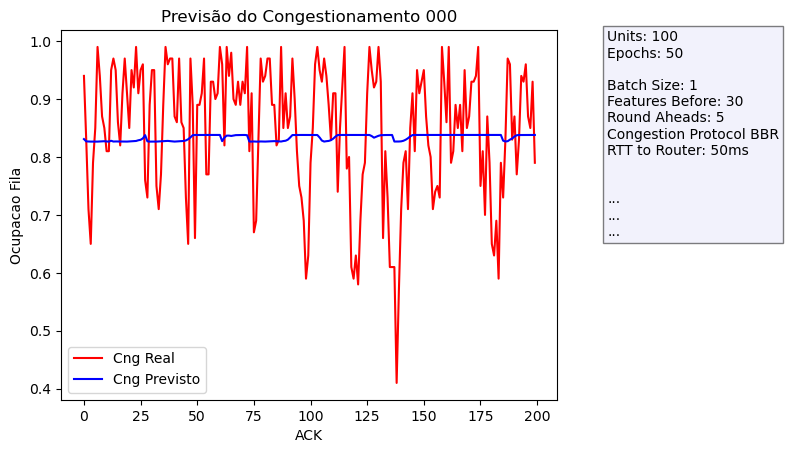

##################Round  1  ##################################
7/7 [==============================] - 1s 21ms/step


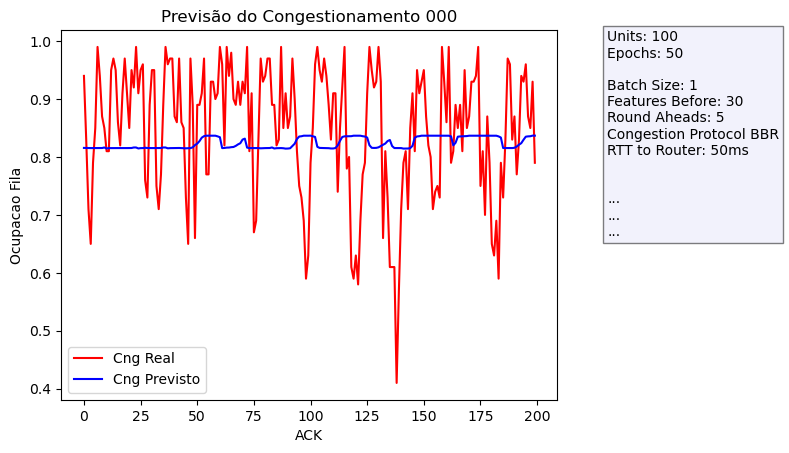

In [5]:
description = "Terminais: 40, 20 longos (4GB), 10 Very Short (10KB) e 10 Short (100KB), entrando no terço final da simulação.  "+"\n"  
description =description + "Topologia: Dumbell (1000MB,1MB de bottleneck), Terminal base 10ms; servidor 100ms;  RTT1=100ms, Salto RTT= 50ms. \n"
description =description + "Tempo de Simulação:60min.\n"
description = description+ "Não-longos para o terço final da simulação.\n"


GeneralTraining(parExpDir="./Exp_0000012/",
                parTrainingPath="./Exp_0000012/training_client01.csv",
                parTestPath="./Exp_0000012/test_client01.csv",
                parExpDescription=description)


Vamos fazer com o CUBIC